# Load Libraries

In [2]:
import pandas as pd
import numpy as np
import credentials
import pickle
import psycopg2
import datetime
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import preprocessing
from sklearn.model_selection import learning_curve,GridSearchCV,train_test_split, RandomizedSearchCV
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import matplotlib.pylab as plt
import matplotlib.pyplot as plt1
from matplotlib import pyplot


# Connect to SQL Database

- For the first time accessing the data, read it directly from SQL

In [2]:
con=psycopg2.connect(dbname= credentials.dbname, host=credentials.host, 
port= credentials.port, user= credentials.user, password= credentials.password)


## Open the query that creates my modeling dataset


In [3]:
fd = open(r'/Users/miqui/Documents/Miqui/Preply/Tutor Performance/Projects/Q3/TWA/TWA Predict/TWA_Query.sql', 'r')
twa_query = fd.read()
fd.close()
file = open('/Users/miqui/Documents/Miqui/Preply/Tutor Performance/Projects/Q3/TWA/TWA Predict/TWA_Query.sql').read()

## Create a modeling DataFrame based on the query

- This is the DataFrame that will be used to train and test the XGBOOST model

In [311]:
data = pd.read_sql(file, con)

In [304]:
data.to_csv("full_dataset.csv")

In [3]:
data = pd.read_csv('/Users/miqui/Documents/Miqui/Preply/Tutor Performance/Projects/Q3/TWA/TWA Predict/full_dataset.csv', parse_dates = ['lesson_ts'])

## Create prediciting DataFrame

- This dataset will be used to predict the probability that the tutor does a TWA based on the averages of the metrics used to train the model
- Note that in order to train the model, we used a dataset based per each lesson while in this case we have reduced the dataset at the tutor level
- It will be used for backtesting. The "prdicitng" dataframe is based on the first 4 months of the dataset, while the evaluation dataset contains information of the last 2 months

In [232]:
data['lesson_ts'] = data['lesson_ts'].apply(lambda x: x.date())

In [236]:
data_predict = data[data['lesson_ts']<datetime.date(2021,5,28)]

,Unnamed: 0,Unnamed: 0.1,tutor_id,student_id,subject,lesson_ts,previous_lesson,duration,is_back_to_back_lesson,created_ts,...,local_booking_time,hour_offset_tutor,hour_offset_student,hour_differences_tutor_student,local_booking_time_date,local_booking_hour,num_lessons_per_day,one_lesson_per_day,app_usage,response_time
0,0,0,39,1331272,english,2021-01-30,NaN,1.0,0,2021-01-28 19:30:42.879612,...,2021-01-28 21:30:42.879612,2,1.0,1.0,2021-01-28,21,1,1,0,NaN
1,1,1,39,1331272,english,2021-02-01,2021-01-30 08:30:00.000000,1.0,0,2021-01-30 09:45:23.384760,...,2021-01-30 11:45:23.384760,2,1.0,1.0,2021-01-30,11,1,1,0,NaN
2,2,2,39,1331272,english,2021-02-03,2021-02-01 08:00:00.000000,1.0,0,2021-02-02 15:49:16.771457,...,2021-02-02 17:49:16.771457,2,1.0,1.0,2021-02-02,17,1,1,0,NaN
3,3,3,39,1331272,english,2021-02-05,2021-02-03 08:00:00.000000,1.0,0,2021-02-03 15:17:45.400003,...,2021-02-03 17:17:45.400003,2,1.0,1.0,2021-02-03,17,1,1,0,NaN
4,4,4,39,1331272,english,2021-02-08,2021-02-05 08:00:00.000000,1.0,0,2021-02-06 10:20:03.397388,...,2021-02-06 12:20:03.397388,2,1.0,1.0,2021-02-06,12,1,1,0,NaN


In [240]:
# Get the explanatory variables

data_predict = data_predict[['tutor_id', 'is_back_to_back_lesson', 'booking_window', 'first_lesson', 'days_since_last_seen', 'local_lesson_hour', 'num_twa_last_30d', 'trial_lesson', 'hour_differences_tutor_student', 'local_booking_hour',
'one_lesson_per_day', 'app_usage', 'response_time']]


In [238]:
# Take the mean for each tutor of all the explanatory variables in order to predict at the tutor level:

data_predict = data_predict.groupby('tutor_id').mean()

In [239]:
data_predict.reset_index(inplace=True)

## Creation of the evaluation DataSet

- This is the dataset that will be used to evaluate the backtest. It contains the last 2 months of data.
- In this case we only want to know if the tutor ha done a TWA in the last 2 months.
- We will compare the output of the Predicting model (will say if a tutor is predicted as potential TWA or not) with the evaulation dataset in orde if they actually did a TWA or not.

In [241]:
data_evaluate = data[data['lesson_ts']>=datetime.date(2021,5,28)]

In [242]:
# Has the tutor done a TWA in the last 2 months?

data_evaluate = data_evaluate[['tutor_id', 'twa_flag']].groupby('tutor_id').max().reset_index()

# Data Exploration

## General info

In [244]:
# Get info on null values

data.info(memory_usage = False, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3964790 entries, 0 to 3964789
Data columns (total 35 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   Unnamed: 0                          3964790 non-null  int64  
 1   Unnamed: 0.1                        3964790 non-null  int64  
 2   tutor_id                            3964790 non-null  int64  
 3   student_id                          3964790 non-null  int64  
 4   subject                             3964790 non-null  object 
 5   lesson_ts                           3964790 non-null  object 
 6   previous_lesson                     3927273 non-null  object 
 7   duration                            3964790 non-null  float64
 8   is_back_to_back_lesson              3964790 non-null  int64  
 9   created_ts                          3964790 non-null  object 
 10  booking_window                      3964790 non-null  int64  
 11  lesson_id  

# Exploring the target variable (TWA)

## TWA Rate 

In [41]:
print(f'The TWA rate of all the lessons is {round(100*(data["twa_flag"].value_counts()[1] / data["twa_flag"].value_counts()[0]),2)}%')
print(f'The TWA rate of trial lessons is {round(100*(data[data["trial_lesson"]==1]["is_twa"].value_counts()[1] / data[data["trial_lesson"]==1]["is_twa"].value_counts()[0]),2)}%') 
print(f'The TWA rate of non trial lessons is {round(100*(data[data["trial_lesson"]==0]["is_twa"].value_counts()[1] / data[data["trial_lesson"]==0]["is_twa"].value_counts()[0]),2)}%')

The TWA rate of all the lessons is 0.86%
The TWA rate of trial lessons is 3.71%
The TWA rate of non trial lessons is 0.61%


## Dealing with null values

### Drop all rows that have a null value

- This seems to be the most conservative apporach since response time has a lot of null values and it is also a very important variable in terms of feature importance
    - I would rather not "make up" values for this variables

In [251]:
# Drop all rows that have any null value
data["is_twa"] = data["twa_flag"]
data_new = data.dropna()

In [43]:
# Having dropped all null values, the TWA rate for trial lessons decreases quite a lot.

print(f'The TWA rate of all the lessons is {round(100*(data_new["twa_flag"].value_counts()[1] / data_new["twa_flag"].value_counts()[0]),2)}%')
print(f'The TWA rate of trial lessons is {round(100*(data_new[data_new["trial_lesson"]==1]["is_twa"].value_counts()[1] / data_new[data_new["trial_lesson"]==1]["is_twa"].value_counts()[0]),2)}%') 
print(f'The TWA rate of non trial lessons is {round(100*(data_new[data_new["trial_lesson"]==0]["is_twa"].value_counts()[1] / data_new[data_new["trial_lesson"]==0]["is_twa"].value_counts()[0]),2)}%')

The TWA rate of all the lessons is 0.83%
The TWA rate of trial lessons is 3.19%
The TWA rate of non trial lessons is 0.63%


# Definition of X and y

In [252]:
X = data_new[['is_back_to_back_lesson', 'booking_window',
         'first_lesson',
       'days_since_last_seen',
       'local_lesson_hour',
      'num_twa_last_30d',
      'trial_lesson',
       'hour_differences_tutor_student',
       'local_booking_hour',
       'one_lesson_per_day', 'app_usage', 'response_time']]
       
y = data_new[['is_twa']]


# Training model

- First iteration

In [253]:
# Model:

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
model = XGBClassifier(eval_metric = 'auc')
eval_set  = [( X_train, y_train), ( X_test, y_test)]
model.fit(X_train, y_train,eval_set=eval_set,early_stopping_rounds=10)

import pickle
file_name = "twa_20210514.pkl"
# save
pickle.dump(model, open(file_name, "wb"))

y_pred = model.predict(X_test)

/Users/miqui/opt/anaconda3/envs/proyecto_final/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/miqui/opt/anaconda3/envs/proyecto_final/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-auc:0.82090	validation_1-auc:0.82136
[1]	validation_0-auc:0.82494	validation_1-auc:0.82567
[2]	validation_0-auc:0.82635	validation_1-auc:0.82722
[3]	validation_0-auc:0.82642	validation_1-auc:0.82766
[4]	validation_0-auc:0.82681	validation_1-auc:0.82763
[5]	validation_0-auc:0.82811	validation_1-auc:0.82953
[6]	validation_0-auc:0.83010	validation_1-auc:0.83128
[7]	validation_0-auc:0.83093	validation_1-auc:0.83163
[8]	validation_0-auc:0.83216	validation_1-auc:0.83296
[9]	validation_0-auc:0.83550	validation_1-auc:0.83545
[10]	validation_0-auc:0.83705	validation_1-auc:0.83667
[11]	validation_0-auc:0.83782	validation_1-auc:0.83741
[12]	validation_0-auc:0.83917	validation_1-auc:0.83856
[13]	validation_0-auc:0.83980	validation_1-auc:0.83894
[14]	validation_0-auc:0.84125	validation_1-auc:0.84003
[15]	validation_0-auc:0.84166	validation_1-auc:0.84023
[16]	validation_0-auc:0.84284	validation_1-auc:0.84064
[17]	validation_0-auc:0.84471	validation_1-auc:0.84203
[18]	validation_0-au

## Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

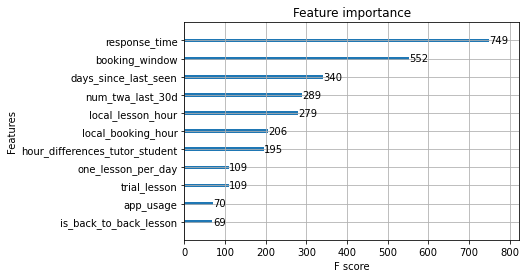

In [254]:
# See the importance of each variable in the model

plot_importance(model)

## Confusion Matrix

- Get the recall of the model in order to see how many of the TWA lessons was the model able to identify

In [256]:
# Super low recall. The model is not able to identify many ones in the dataset. This is probably due to the fact that the target variable is very undersampled

cm = confusion_matrix(y_test, y_pred)
recall = cm[1,1]/(cm[1,1] + cm[1,0])
recall

0.025137568784392196

## Dealing with undersampled target variable

In [263]:
print(f'The proportion of ones in the target variable is: {round(100*y.value_counts()[1] / (y.value_counts()[1]+ y.value_counts()[0]),2)}%')

The proportion of ones in the target variable is: 0.82%


## Smoteen oversampling

- This method will add ones to the target variable based on the KNN method. Basically, it will add ones to those rows that are currently zeroes but are similar to the rows that have ones

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
y_train.value_counts()

is_twa
0         1951443
1           16208
dtype: int64

In [264]:
# Create a Pipeline with the SMOTEEN oversampling method

over = [('over', SMOTEENN())]
pipe = Pipeline(steps =over)
X_train_new,y_train_new = pipe.fit_resample(X_train,y_train)

In [266]:
# Now we get a much more balanced target variable

print(f'The proportion of ones in the target variable is: {round(100*y_train_new.value_counts()[1] / (y_train_new.value_counts()[1]+ y_train_new.value_counts()[0]),2)}%')

The proportion of ones in the target variable is: 52.1%


In [329]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.038664 using {'learning_rate': 0.2}


In [271]:
# Model:

seed = 7
test_size = 0.33
model = XGBClassifier(max_depth=5,
                           min_child_weight=9,
                           learning_rate=0.05,
                           n_estimators=80,
                           objective='binary:logistic',
                           eval_metric = 'auc',
                           gamma=0,
                           max_delta_step=0,
                           subsample=0.8,
                           colsample_bytree=0.86,
                           colsample_bylevel=0.67,
                           reg_alpha=0,
                           reg_lambda=2.8,
                           scale_pos_weight=1,
                           seed=1)
eval_set  = [( X_train_new, y_train_new), ( X_test, y_test)]
model.fit(X_train_new, y_train_new,eval_set=eval_set,early_stopping_rounds=10)

import pickle
file_name = "twa_20210514.pkl"
# save
pickle.dump(model, open(file_name, "wb"))

y_pred = model.predict_proba(X_test)

/Users/miqui/opt/anaconda3/envs/proyecto_final/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/miqui/opt/anaconda3/envs/proyecto_final/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-auc:0.84722	validation_1-auc:0.72270
[1]	validation_0-auc:0.91763	validation_1-auc:0.72886
[2]	validation_0-auc:0.92725	validation_1-auc:0.73904
[3]	validation_0-auc:0.92588	validation_1-auc:0.74676
[4]	validation_0-auc:0.92307	validation_1-auc:0.75440
[5]	validation_0-auc:0.93103	validation_1-auc:0.75603
[6]	validation_0-auc:0.93369	validation_1-auc:0.75446
[7]	validation_0-auc:0.93658	validation_1-auc:0.75399
[8]	validation_0-auc:0.93850	validation_1-auc:0.76560
[9]	validation_0-auc:0.93902	validation_1-auc:0.76133
[10]	validation_0-auc:0.93910	validation_1-auc:0.76272
[11]	validation_0-auc:0.93829	validation_1-auc:0.76264
[12]	validation_0-auc:0.93845	validation_1-auc:0.76213
[13]	validation_0-auc:0.94269	validation_1-auc:0.76269
[14]	validation_0-auc:0.94277	validation_1-auc:0.76458
[15]	validation_0-auc:0.94252	validation_1-auc:0.76137
[16]	validation_0-auc:0.94192	validation_1-auc:0.75988
[17]	validation_0-auc:0.94177	validation_1-auc:0.76033
[18]	validation_0-au

In [300]:
y_pred = model.predict_proba(X_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

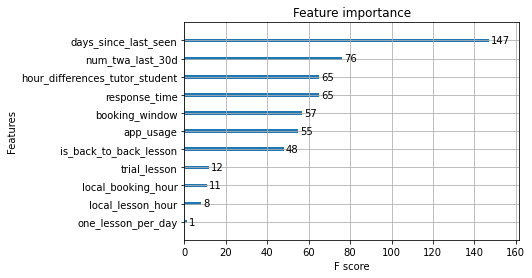

In [272]:
# Feature imoortance of the variables in the model

plot_importance(model)

In [1]:
# Check the Confussion matrix of the model

cm = confusion_matrix(y_test, y_pred)
recall = cm[1,1]/(cm[1,1] + cm[1,0])

cm

NameError: name 'confusion_matrix' is not defined

In [277]:
# Check out the classification report of the model

# We are able to identify more than half of the lessons that were TWA. We only identify 12% of classes as False Positives. As a company, we are more concerned with getting 
# as much true positives as possible and only 12% of False Negatives is not something to worry about.
# It is better to flag more classes as potential TWA even if it means getting some of them that will not do TWA


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93    961146
           1       0.03      0.50      0.06      7996

    accuracy                           0.87    969142
   macro avg       0.51      0.69      0.50    969142
weighted avg       0.99      0.87      0.92    969142



# Predicting Code

- Predict at the tutor level
- We want to do a Backtest in order to see if those tutor who we predict as Potential TWA 2 months ago, actually did a TWA in the 2 months after that

In [292]:
# Predicting code:

file = open("twa_20210514.pkl",'rb')
twa_model = pickle.load(file)
file.close()


data_predict['twa_prob'] = twa_model.predict_proba(data_predict[twa_model.get_booster().feature_names])[:,1]
data_predict['is_bad_twa_pred'] = 1*(data_predict['twa_prob']>=0.6)
data_predict_final = data_predict[['tutor_id', 'twa_prob', 'is_bad_twa_pred']]


# Check results

In [293]:
# This is the threshold we will be using

np.mean(data_check['twa_prob'])

0.600741446018219

In [294]:
data_check = pd.merge(data_predict_final, data_evaluate, on = 'tutor_id')

In [295]:


data_check['check'] = np.where(data_check['is_bad_twa_pred'] == data_check['twa_flag'], 'true', 'false')

In [296]:
data_check['is_bad_twa_pred'].value_counts()

1    12759
0     9050
Name: is_bad_twa_pred, dtype: int64

In [297]:
data_check.to_csv('to_sql091.csv')

In [298]:
data['is_twa'].value_counts()

0    3930790
1      34000
Name: is_twa, dtype: int64

In [299]:
# Check what's the % of tutors that we got right:

data_check[data_check['twa_flag']==1]['check'].value_counts()[1]

true     3419
false    1280
Name: check, dtype: int64